In [206]:
import numpy as np

def bin2(val, width):
        if val < 0:
            return bin((1 << width) + val)[2::]
        else:
            return bin(val)[2::].zfill(width)

class FixedPoint:
    # The python fixedpoint library is only supported in python3.8
    # Since modelsim requires 32 bit python this class was required

    def __init__(self, val, int_bits=8,fract_bits=8):
        self.int_bits = int_bits
        self.fract_bits = fract_bits
        self.bit_width = int_bits + fract_bits
        self.fxp = self.convert_to_fxp(val)

    def convert_to_fxp(self, val):
        val_type = type(val)
        if(val_type == float or val_type == np.float64):
            return bin2(int(val*(2**self.fract_bits)), self.bit_width)
        elif (val_type == str):
            if len(val) != self.bit_width:
                raise Exception(f"Binstr len {len(val)} != {self.bit_width}")
            return val
        else:
            raise Exception(f"FXP conversion not implemented for {val_type}")

    def __float__(self):
        bin_vec = [int(b == '1') for b in self.fxp]
        int_val = 0
        for i, b in enumerate(bin_vec):
            int_val += b * 2 ** (self.bit_width - i - 1)
        if bin_vec[0]:
            int_val -= 2**self.bit_width
        
        return float(int_val / 2**self.fract_bits)

    def __add__(self, v):
        return FixedPoint(float(self) + float(v))
    
    def __sub__(self, v):
        return FixedPoint(float(self) - float(v))
    
    def __mul__(self, v):
        return FixedPoint(float(self) * float(v))
        
    def __str__(self):
        return self.fxp
    def __repr__(self):
        return f"Q{self.int_bits}.{self.fract_bits} bin_str: {self.fxp}"

if __name__ == "__main__":
    x = FixedPoint(-0.5, 1, 7)
    print(float(x))

-0.5


b is [ 0.0722087 -0.1184396  0.0295316  0.        -0.0295316  0.1184396
 -0.0722087] with length 7
a is [ 1.         -3.53765472  6.09296135 -6.53471342  4.61508975 -1.99552106
  0.42426474] with length 7


/Users/rbk/opt/anaconda3/envs/sleep/lib/python3.7/site-packages/scipy/signal/filter_design.py:4135: RuntimeWarning: divide by zero encountered in true_divide
  (stopb * (passb[0] - passb[1])))


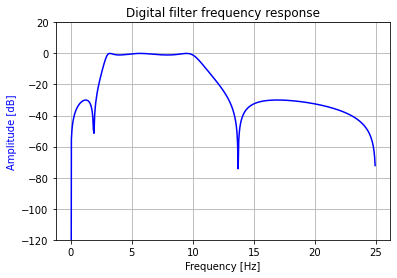

In [201]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

fs = 50
f_nyquist = fs/2
stopband = [0,13]
passband = [3,10]

wp = [x/f_nyquist for x in passband]
ws = [x/f_nyquist for x in stopband]

# wp = [0.2, 0.5]
# ws = [0.1, 0.6]
gpass = 1
gstop = 30

system = signal.iirdesign(wp, ws, gpass, gstop)
w, h = signal.freqz(*system)
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')
ax1.plot(fs*w/(2*np.pi), 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.grid()
ax1.set_ylim([-120, 20])
b = system[0]
a = system[1]
print(f"b is {b} with length {len(b)}")
print(f"a is {a} with length {len(a)}")

In [202]:
f_nyquist = fs/2
w_start = 3/f_nyquist
w_stop = 11/f_nyquist
print(w_start)
print(w_stop)
b, a = signal.iirfilter(1, [w_start, w_stop], btype='band', analog=False, ftype='butter')
print(b)
print(a)

0.12
0.44
[ 0.35473657  0.         -0.35473657]
[ 1.         -0.93872704  0.29052686]


In [203]:
f_nyquist = 50/2
w_start = 3/f_nyquist
w_stop = 11/f_nyquist
coefficients = signal.firwin(31, [w_start, w_stop], pass_zero=False)
print(coefficients)

[ 0.00259893  0.00270108  0.00061784  0.00093804  0.00886424  0.01510628
  0.00172681 -0.02187372 -0.01943253  0.00483559 -0.01771551 -0.11293005
 -0.16841245 -0.04810775  0.19252969  0.31834775  0.19252969 -0.04810775
 -0.16841245 -0.11293005 -0.01771551  0.00483559 -0.01943253 -0.02187372
  0.00172681  0.01510628  0.00886424  0.00093804  0.00061784  0.00270108
  0.00259893]


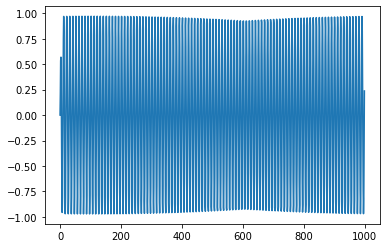

(array([ 0.0722087, -0.1184396,  0.0295316,  0.       , -0.0295316,
        0.1184396, -0.0722087]), array([ 1.        , -3.53765472,  6.09296135, -6.53471342,  4.61508975,
       -1.99552106,  0.42426474]))


In [213]:
from collections import deque
#b = [0.072, -0.118, 0.030, 0., -0.030, 0.118, -0.072]
#a = [1., -3.538, 6.093, -6.535,  4.615, -1.995, 0.42426474]

b = [ 0.355 , 0.  ,       -0.355]
a = [ 1.       ,  -0.939,  0.291]

class IIR:
    def __init__(s, b, a):
        s.b = b
        s.a = a
        s.x_n = deque((len(a)-1)*[0], maxlen=len(a)-1)
        s.y_n = deque((len(b)-1)*[0], maxlen=len(b)-1)
        s.iteration = 0
    
    def update(s, x):
        feedforward = 0.0
        feedback = 0.0
        feedforward = s.b[0] * x
        for i in range(len(s.x_n)):
            feedforward += s.b[i+1] * s.x_n[i]
            feedback += -s.a[i+1]*s.y_n[i]
            
        y = feedforward + feedback
        
        s.x_n.appendleft(x)
        s.y_n.appendleft(y)
        s.iteration +=1
        
        return y

n = 1000
fs = 50
f0 = 5
amp0 = 1
x = np.linspace(0, n/fs, n)
xs = amp0 * np.sin(2*np.pi*x*f0)
irr_filt = IIR(b, a)
ys = [irr_filt.update(x) for x in xs]
#ys = [irr_filt.update(x) for x in ys]
#ys = signal.lfilter(b, a, xs)
plt.figure()
#plt.plot(xs)
plt.plot(ys)
plt.show()
print(system)

In [209]:
b_fxp = [FixedPoint(x, 1, 7) for x in b]
print(b_fxp)
print([float(b) for b in b_fxp])

[Q1.7 bin_str: 00101101, Q1.7 bin_str: 00000000, Q1.7 bin_str: 11010011]
[0.3515625, 0.0, -0.3515625]


In [214]:
a_fxp = [FixedPoint(-x, 1, 7) for x in a]
print(a_fxp)
print([float(a) for a in a_fxp])

[Q1.7 bin_str: 10000000, Q1.7 bin_str: 01111000, Q1.7 bin_str: 11011011]
[-1.0, 0.9375, -0.2890625]
